In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import os
import sys
import time
import json
import copy
import cortex
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Plotly imports
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Personal imports
sys.path.append("{}/../../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface
from maths_utils import weighted_regression

In [2]:
# Directories
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'

In [12]:
# General settings
with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
TRs = analysis_info['TRs']
subjects = analysis_info['subjects']
rois = analysis_info['rois']
rois_groups = analysis_info['rois_groups']

with open('../../figure_settings.json') as f:
    json_s = f.read()
    figure_info = json.loads(json_s)
plot_groups = figure_info['plot_groups']
fig_width = figure_info['fig_width']
ecc_threshold = analysis_info['ecc_th']
size_threshold = analysis_info['size_th']
rsqr_threshold = analysis_info['rsqr_th']
amplitude_threshold = analysis_info['amplitude_th']
stats_threshold = analysis_info['stats_th']
n_threshold = analysis_info['n_th']

In [4]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

port_num = 25000

In [5]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)
standoff = 8

In [6]:
# Plot settings
roi_colors_dict = {'V1': 'rgb(243, 231, 155)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}


# pRF plots

## ECC size

### Function

In [7]:
def prf_ecc_size_plot(df_ecc_size, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc, max_size):
    """
    Make scatter plot for linear relationship between eccentricity and size

    Parameters
    ----------
    df_ecc_size : A data dataframe
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : list of rgb colors for plotly
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity 
    
    Returns
    -------
    fig : eccentricy as a function of size plot
    """
    
    from maths_utils import weighted_regression

    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):
            
            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_size.loc[(df_ecc_size.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            size_median = np.array(df.prf_size_bins_median)
            r2_median = np.array(df.prf_loo_r2_bins_median)
            size_upper_bound = np.array(df.prf_size_bins_ci_upper_bound)
            size_lower_bound = np.array(df.prf_size_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_median, size_median, r2_median, model='linear')
            slope_upper, intercept_upper = weighted_regression(ecc_median[np.where(~np.isnan(size_upper_bound))], 
                                                               size_upper_bound[~np.isnan(size_upper_bound)], 
                                                               r2_median[np.where(~np.isnan(size_upper_bound))], 
                                                               model='linear')
            
            slope_lower, intercept_lower = weighted_regression(ecc_median[np.where(~np.isnan(size_lower_bound))], 
                                                               size_lower_bound[~np.isnan(size_lower_bound)], 
                                                               r2_median[np.where(~np.isnan(size_lower_bound))], 
                                                               model='linear')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = slope * line_x + intercept
            line_upper = slope_upper * line_x + intercept_upper
            line_lower = slope_lower * line_x + intercept_lower

            fig.add_trace(go.Scatter(x=line_x, y=line, mode='lines', name=roi, legendgroup=roi, 
                                      line=dict(color=roi_color, width=3), showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]), 
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=size_median, mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=size_upper_bound - size_median, 
                                                  arrayminus=size_median - size_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                      marker=dict(color=roi_color,
                                                  symbol='square',
                                                  size=8, 
                                                  line=dict(color=roi_color, 
                                                            width=3)), 
                                      showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=1, y=20-j*1.5, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)
            
            
        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF size (dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_size], showline=True, tickmode="array", tickvals=np.linspace(0,max_size,4), ticktext=[str(x) for x in np.linspace(0, max_size, 4).astype(int)])
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=470, margin_r=470, margin_t=50, margin_b=100)
        


        
    return fig

### Plot

In [8]:
# Settings
subject = 'group'
format_ = '170k'
suffix = 'Sac_Pur'

max_ecc = 15
max_size = 18

# tresholds
ecc_th = [0, 15]
size_th= [0.1, 20]
rsq_th = [0, 1]
pcm_th = [0,20]

plot_groups = [['iIPS', 'sIPS'],['iPCS', 'sPCS', 'mPCS']]
# plot_groups = [['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'],['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']]
rois = ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

In [9]:
# Load data
intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
df_ecc_size = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_size_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))


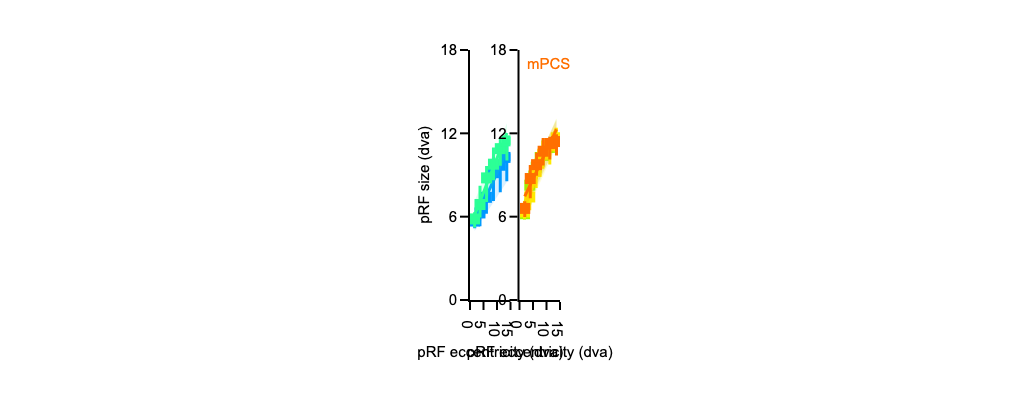

In [10]:
# Plot
fig = prf_ecc_size_plot(df_ecc_size=df_ecc_size, fig_width=fig_width, 
                        fig_height=400, rois=rois, roi_colors=roi_colors_dict,
                        plot_groups=plot_groups, max_ecc=max_ecc, max_size=max_size)

fig.show()
fig_dir = '/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/ecc_size_pcm'

fig.write_image("{}/{}_ecc_size.pdf".format(fig_dir, subject))
# fig.write_image("/Users/uriel/Downloads/{}_ecc_size.pdf".format(subject))
# fig.write_image("{}/{}_ecc_size2.pdf".format(fig_dir, subject))

### Stats 

In [13]:
df_stats = pd.DataFrame()
# for subject in subjects :
for subject in subjects :
    intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
    tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/tsv'.format(main_dir, project_dir, subject, format_)

    df_ecc_size = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_size_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))
    # for roi in rois: 
    for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']: 
        df_stats_roi = pd.DataFrame()
        # Get data
        df_ecc_size_roi = df_ecc_size.loc[(df_ecc_size.roi == roi)]
        
        ecc_median = np.array(df_ecc_size_roi.prf_ecc_bins)
        size_median = np.array(df_ecc_size_roi.prf_size_bins_median)
        r2_median = np.array(df_ecc_size_roi.prf_loo_r2_bins_median)
        
        # Creat model 
        slope, intercept = weighted_regression(ecc_median, size_median, r2_median, model='linear')
        
        # Load data
        df_pRF = pd.read_table('{}/{}_css-all_derivatives.tsv'.format(tsv_dir,subject))
        
        # Threshold data (replace by nan)
        if stats_threshold == 0.05: stats_col = 'corr_pvalue_5pt'
        elif stats_threshold == 0.01: stats_col = 'corr_pvalue_1pt'
        df_pRF.loc[(df_pRF.amplitude < amplitude_threshold) |
                 (df_pRF.prf_ecc < ecc_threshold[0]) | (df_pRF.prf_ecc > ecc_threshold[1]) |
                 (df_pRF.prf_size < size_threshold[0]) | (df_pRF.prf_size > size_threshold[1]) | 
                 (df_pRF.prf_n < n_threshold[0]) | (df_pRF.prf_n > n_threshold[1]) | 
                 (df_pRF.prf_loo_r2 < rsqr_threshold) |
                 (df_pRF[stats_col] > stats_threshold)] = np.nan
        df_pRF = df_pRF.dropna()
        
        
        df_pRF_roi = df_pRF.loc[(df_pRF.roi == roi)]
        
        pred_size_roi = df_pRF_roi.prf_ecc * slope + intercept 
        
        # mask for nan
        mask = ~df_pRF_roi.prf_size.isna() & ~pred_size_roi.isna()

        # linear regression between model and data 
        results = stats.linregress(x=pred_size_roi[mask], y=df_pRF_roi.prf_size[mask], alternative='greater')
        
        df_stats_roi['subject'] = [subject]
        df_stats_roi['roi'] = [roi]
        df_stats_roi['rvalue'] = [results.rvalue]
        df_stats_roi['pvalue'] = [results.pvalue]
        
        df_stats = pd.concat([df_stats, df_stats_roi])
        

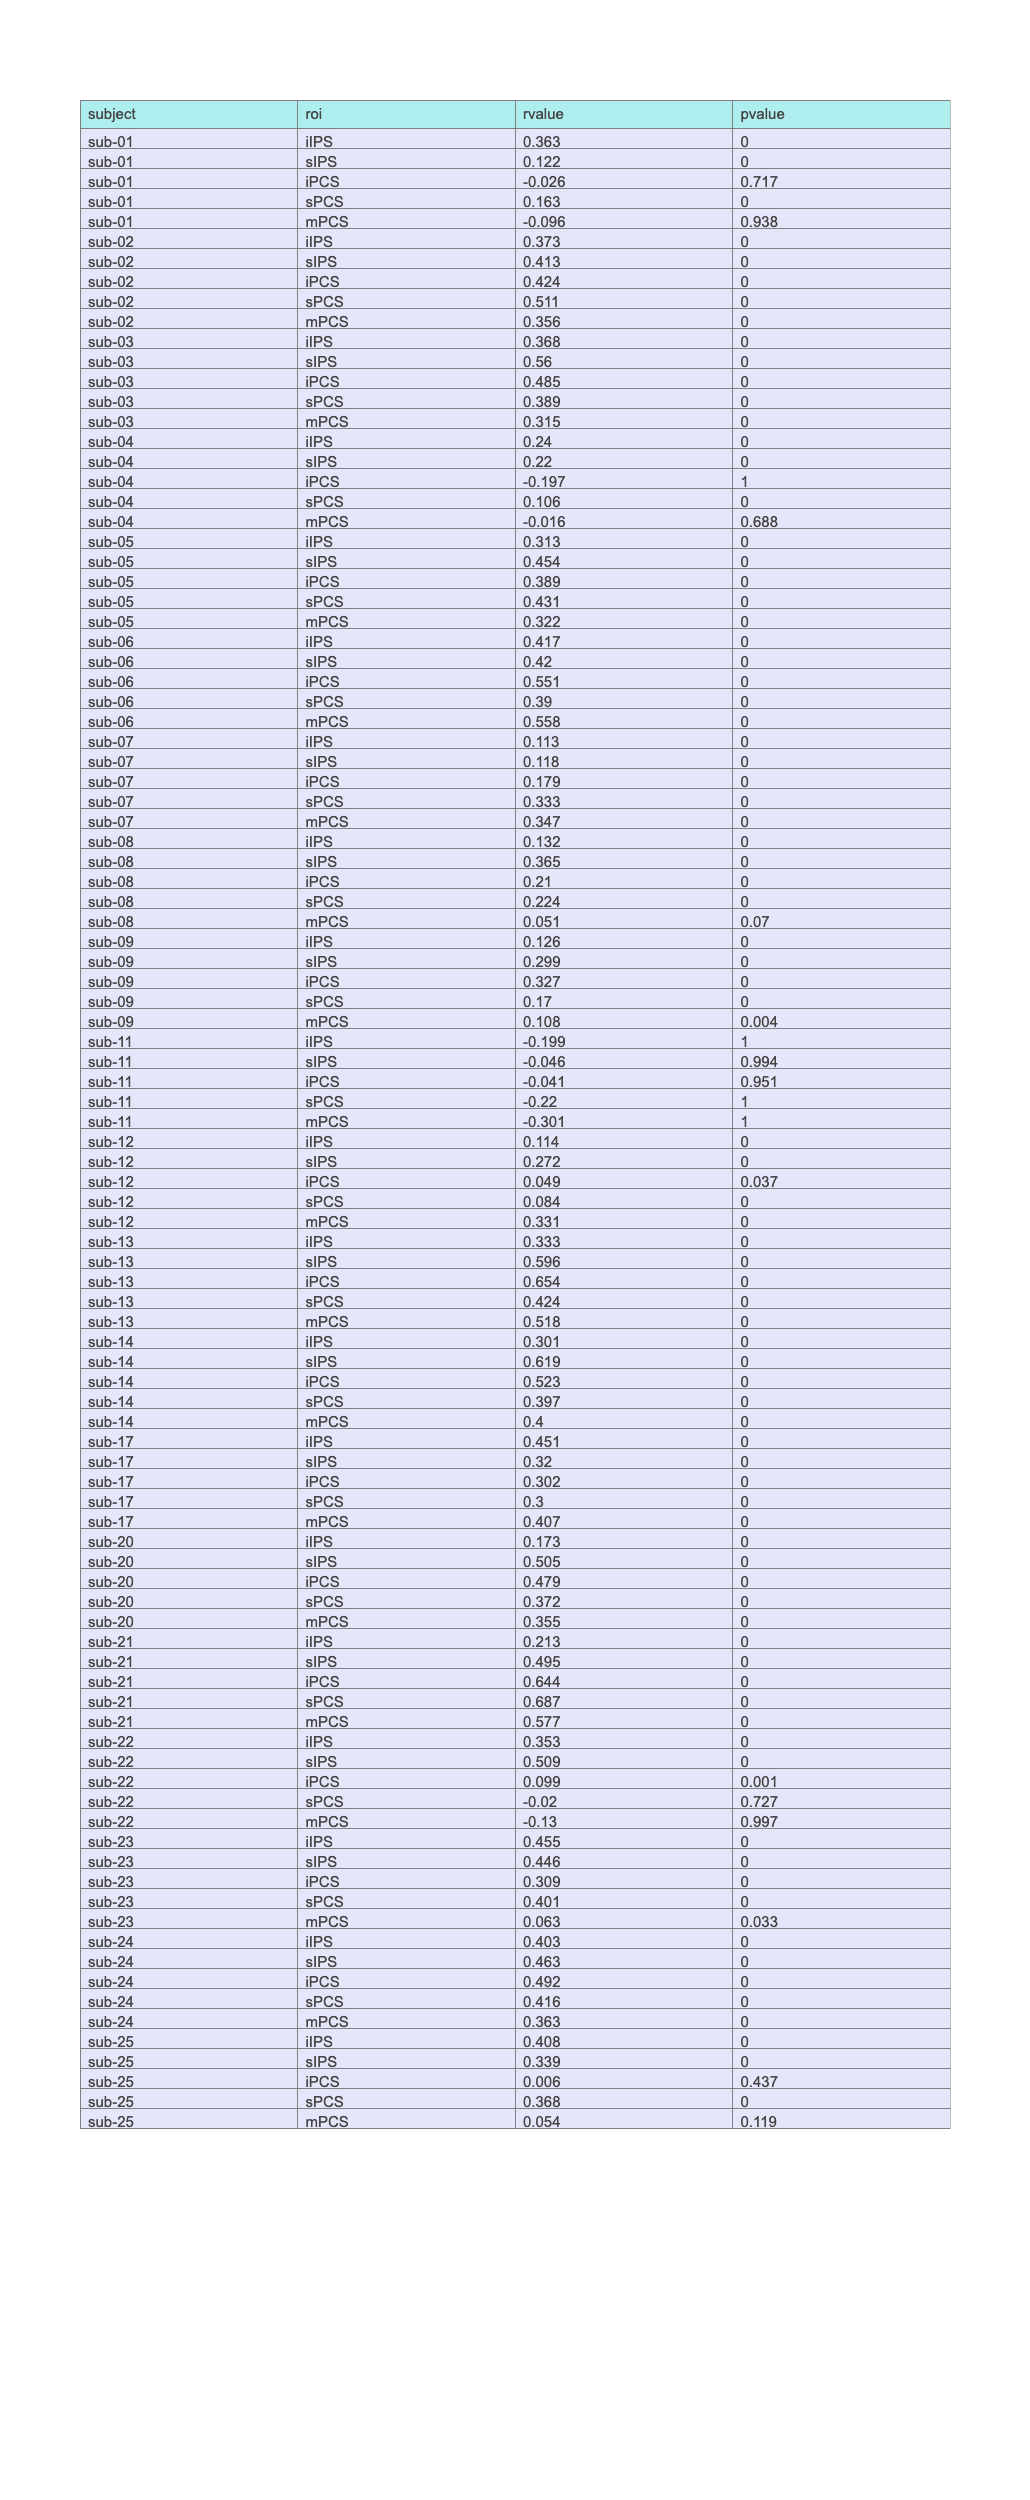

In [14]:
fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(df_stats.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[df_stats[col].round(3) for col in df_stats.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=2500, 
                  width=1200)
# fig.write_image("/Users/uriel/Downloads/ecc_size_stats2.pdf".format(subject))
# fig.show()


In [16]:
print('ecc / size relation signifante subjects')
for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'] : 
    df_stats_roi_significant = df_stats.loc[(df_stats['roi']==roi)&(df_stats['pvalue'] < 0.01)]
    
    print('{}'. format(roi))
    print('all p-value inferior to {}'.format(df_stats_roi_significant['pvalue'].max()))
    print('r interval : {} {}'.format(df_stats_roi_significant['rvalue'].min().round(2), df_stats_roi_significant['rvalue'].max().round(2)))


ecc / size relation signifante subjects
iIPS
all p-value inferior to 1.294307262652851e-05
r interval : 0.11 0.46
sIPS
all p-value inferior to 4.412988945162711e-06
r interval : 0.12 0.62
iPCS
all p-value inferior to 0.0011728049989917753
r interval : 0.1 0.65
sPCS
all p-value inferior to 4.713786726725722e-06
r interval : 0.08 0.69
mPCS
all p-value inferior to 0.0035003779335668053
r interval : 0.11 0.58


In [15]:
print('ecc / size relation non signifante subjects')
for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']:
    df_stats_roi_significant = df_stats.loc[(df_stats['roi'] == roi) & (df_stats['pvalue'] > 0.01)]
    
    if df_stats_roi_significant.empty:
        print('{}: no subject non significant'.format(roi))
        continue  # Passer à l'itération suivante si df_stats_roi_significant est vide
    
    print('{}'.format(roi))
    print('{} subject(s) is / are not significative : ({})'.format(df_stats_roi_significant['subject'].shape[0] , df_stats_roi_significant['subject'].values))
    print('all p-value superior to {}'.format(df_stats_roi_significant['pvalue'].min()))
    print('r interval : {} {}'.format(df_stats_roi_significant['rvalue'].min().round(2), df_stats_roi_significant['rvalue'].max().round(2)))


ecc / size relation non signifante subjects
iIPS
1 subject(s) is / are not significative : (['sub-11'])
all p-value superior to 1.0
r interval : -0.2 -0.2
sIPS
1 subject(s) is / are not significative : (['sub-11'])
all p-value superior to 0.9942731202637056
r interval : -0.05 -0.05
iPCS
5 subject(s) is / are not significative : (['sub-01' 'sub-04' 'sub-11' 'sub-12' 'sub-25'])
all p-value superior to 0.03672277686569663
r interval : -0.2 0.05
sPCS
2 subject(s) is / are not significative : (['sub-11' 'sub-22'])
all p-value superior to 0.7266928194487732
r interval : -0.22 -0.02
mPCS
7 subject(s) is / are not significative : (['sub-01' 'sub-04' 'sub-08' 'sub-11' 'sub-22' 'sub-23' 'sub-25'])
all p-value superior to 0.03270688009623674
r interval : -0.3 0.06


## ECC pCM

### function

In [17]:
def prf_ecc_pcm_plot(df_ecc_pcm, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc, max_pcm):
    """
    Make scatter plot for relationship between eccentricity and pCM

    Parameters
    ----------
    df_ecc_pcm : dataframe for the plot
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : list of rgb colors for plotly
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity
    
    Returns
    -------
    fig : eccentricy as a function of pcm plot
    """

    from maths_utils import weighted_regression
    
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):

            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            pcm_median = np.array(df.prf_pcm_bins_median)
            r2_median = np.array(df.prf_loo_r2_bins_median)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_median, pcm_median, r2_median, model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_median[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_median[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_median[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_median[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=pcm_median, 
                                     mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_median, 
                                                  arrayminus=pcm_median - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=12, y=(20)-j*2, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)
        

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_pcm], showline=True,  nticks=4)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=470, margin_r=470, margin_t=50, margin_b=100)
        
    return fig

### Plot

In [18]:
# Plot settings
roi_colors_dict = {'V1': 'rgb(235, 127, 134)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}


In [19]:
# Settings
subject = 'group'
format_ = '170k'
suffix = 'Sac_Pur'

max_ecc = 15
max_pcm = 6

# tresholds
ecc_th = [0, 15]
size_th= [0.1, 20]
rsq_th = [0, 1]
pcm_th = [0,20]

plot_groups = [['iIPS', 'sIPS'],['iPCS', 'sPCS', 'mPCS']]
# plot_groups = [['V1'],['V1']]
# plot_groups = [['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'],['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']]
# rois = ['V1', 'V1']
rois = ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

In [20]:
intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
df_ecc_pcm = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_pcm_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))

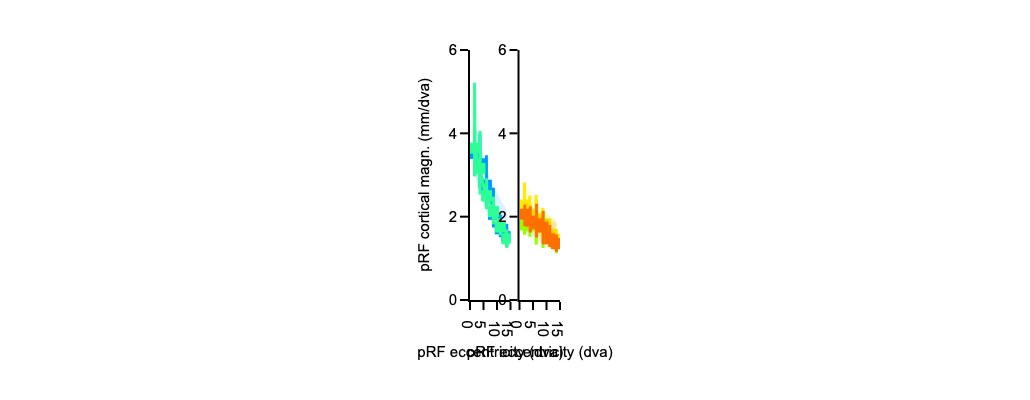

In [21]:
fig = prf_ecc_pcm_plot(df_ecc_pcm=df_ecc_pcm, fig_width=fig_width, fig_height=400, 
                        rois=rois, roi_colors=roi_colors_dict,
                        plot_groups=plot_groups, max_ecc=max_ecc, max_pcm=max_pcm)

fig.show()
fig_dir = '/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/ecc_size_pcm'
fig.write_image("{}/{}_ecc_pCM.pdf".format(fig_dir, subject))
# fig.write_image("/Users/uriel/Downloads/{}_ecc_pCM.pdf".format(subject))

### Stats

In [22]:
df_stats_ecc_pcm = pd.DataFrame()
for subject in subjects :
# for subject in ['sub-07'] :
    intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
    tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/tsv'.format(main_dir, project_dir, subject, format_)

    df_ecc_pcm = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_pcm_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))
    # for roi in rois: 
    for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']: 
    # for roi in ['sIPS']: 
        df_stats_ecc_pcm_roi = pd.DataFrame()
        # Get data
        df_ecc_pcm_roi = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
        
        ecc_median = np.array(df_ecc_pcm_roi.prf_ecc_bins)
        pcm_median = np.array(df_ecc_pcm_roi.prf_pcm_bins_median)
        r2_median = np.array(df_ecc_pcm_roi.prf_loo_r2_bins_median)


        # Creat model 
        slope, intercept = weighted_regression(ecc_median, pcm_median, r2_median, model='pcm')
        
        # Load data
        df_pRF = pd.read_table('{}/{}_css-all_derivatives.tsv'.format(tsv_dir,subject))
        
        # Threshold data (replace by nan)
        if stats_threshold == 0.05: stats_col = 'corr_pvalue_5pt'
        elif stats_threshold == 0.01: stats_col = 'corr_pvalue_1pt'
        df_pRF.loc[(df_pRF.amplitude < amplitude_threshold) |
                 (df_pRF.prf_ecc < ecc_threshold[0]) | (df_pRF.prf_ecc > ecc_threshold[1]) |
                 (df_pRF.prf_size < size_threshold[0]) | (df_pRF.prf_size > size_threshold[1]) | 
                 (df_pRF.prf_n < n_threshold[0]) | (df_pRF.prf_n > n_threshold[1]) | 
                 (df_pRF.prf_loo_r2 < rsqr_threshold) |
                 (df_pRF[stats_col] > stats_threshold)] = np.nan
        df_pRF = df_pRF.dropna()
        
        
        df_pRF_roi = df_pRF.loc[(df_pRF.roi == roi)]
        
        pred_pcm_roi = 1 / (df_pRF_roi.prf_ecc * slope + intercept) 
        
        # mask for nan
        mask = ~df_pRF_roi.pcm_median.isna() & ~pred_pcm_roi.isna()

        # linear regression between model and data 
        results = stats.linregress(x=pred_pcm_roi[mask], y=df_pRF_roi.pcm_median[mask], alternative='greater')
        
        df_stats_ecc_pcm_roi['subject'] = [subject]
        df_stats_ecc_pcm_roi['roi'] = [roi]
        df_stats_ecc_pcm_roi['rvalue'] = [results.rvalue]
        df_stats_ecc_pcm_roi['pvalue'] = [results.pvalue]
        
        df_stats_ecc_pcm = pd.concat([df_stats_ecc_pcm, df_stats_ecc_pcm_roi])
        

In [23]:
fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(df_stats_ecc_pcm.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[df_stats_ecc_pcm[col].round(3) for col in df_stats_ecc_pcm.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=2500, 
                  width=1200)
# fig.write_image("/Users/uriel/Downloads/ecc_pcm_stats2.pdf".format(subject))
# fig.show()

In [24]:
print('ecc / pcm relation signifante subjects')
for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'] : 
    df_stats_roi_significant = df_stats_ecc_pcm.loc[(df_stats['roi']==roi)&(df_stats_ecc_pcm['pvalue'] < 0.01)]
    
    print('{}'. format(roi))
    print('all p-value inferior to {}'.format(df_stats_roi_significant['pvalue'].max()))
    print('r interval : {} {}'.format(df_stats_roi_significant['rvalue'].min().round(2), df_stats_roi_significant['rvalue'].max().round(2)))


ecc / pcm relation signifante subjects
iIPS
all p-value inferior to 1.196785354363595e-11
r interval : 0.18 0.78
sIPS
all p-value inferior to 5.528118857104425e-32
r interval : 0.28 0.81
iPCS
all p-value inferior to 2.0839279662596383e-11
r interval : 0.19 0.66
sPCS
all p-value inferior to 7.870858459078779e-11
r interval : 0.19 0.8
mPCS
all p-value inferior to 2.854366484811104e-05
r interval : 0.15 0.71


In [25]:
print('ecc / pcm relation non signifante subjects')
for roi in ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']:
    df_stats_roi_significant = df_stats_ecc_pcm.loc[(df_stats['roi'] == roi) & (df_stats_ecc_pcm['pvalue'] > 0.01)]
    
    if df_stats_roi_significant.empty:
        print('{}: no subject non significant'.format(roi))
        continue  # Passer à l'itération suivante si df_stats_roi_significant est vide
    
    print('{}'.format(roi))
    print('{} subject(s) is / are not significative : ({})'.format(df_stats_roi_significant['subject'].shape[0] , df_stats_roi_significant['subject'].values))
    print('all p-value superior to {}'.format(df_stats_roi_significant['pvalue'].min()))
    print('r interval : {} {}'.format(df_stats_roi_significant['rvalue'].min().round(2), df_stats_roi_significant['rvalue'].max().round(2)))


ecc / pcm relation non signifante subjects
iIPS
2 subject(s) is / are not significative : (['sub-01' 'sub-08'])
all p-value superior to 0.9999978519103768
r interval : -0.5 -0.19
sIPS
1 subject(s) is / are not significative : (['sub-22'])
all p-value superior to 1.0
r interval : -0.44 -0.44
iPCS
9 subject(s) is / are not significative : (['sub-01' 'sub-06' 'sub-09' 'sub-12' 'sub-17' 'sub-20' 'sub-21' 'sub-23'
 'sub-25'])
all p-value superior to 0.08773688217931364
r interval : -0.56 0.03
sPCS
4 subject(s) is / are not significative : (['sub-04' 'sub-06' 'sub-09' 'sub-25'])
all p-value superior to 0.025167244056571877
r interval : -0.56 0.04
mPCS
5 subject(s) is / are not significative : (['sub-01' 'sub-09' 'sub-21' 'sub-23' 'sub-25'])
all p-value superior to 0.012881148619916993
r interval : -0.61 0.07


# Vertex bar plot group ROI

## Plot

In [17]:
# Specific settings
subject = 'group'
format_ = '170k'
suffix = 'Sac_Pur'

In [18]:
# Load DF 
tsv_dir = '{}/{}/derivatives/pp_data/{}/{}/intertask/tsv'.format(main_dir, project_dir, subject, format_)
active_vertex_tsv_fn = '{}/{}_active_vertex_roi_{}.tsv'.format(tsv_dir, subject, suffix)

df_active_vertex_roi = pd.read_table(active_vertex_tsv_fn)

In [19]:
plot_groups = {'frontal' : ['iPCS', 'sPCS', 'mPCS'],
               'parietal ' : ['iIPS', 'sIPS'] 
              }

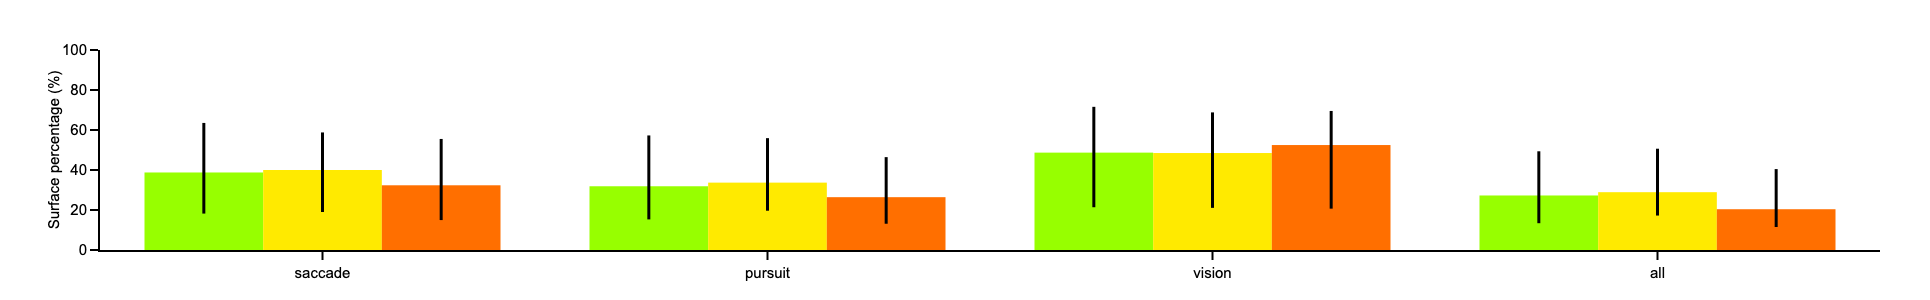

In [21]:
sub_rois =  ['iPCS', 'sPCS', 'mPCS']
# sub_rois =  ['iIPS', 'sIPS']
fig = go.Figure()
for i, roi in enumerate(sub_rois):
    df_roi = df_active_vertex_roi.loc[df_active_vertex_roi['roi']==roi]
    fig.add_trace(go.Bar(
        x=df_roi['categorie'],
        y=df_roi['median'],
        name=roi,  
        marker=dict(color=roi_colors_dict[roi]), 
        error_y=dict(
            type='data',
            array=df_roi['ci_high'] - df_roi['median'], 
            arrayminus=df_roi['median'] - df_roi['ci_low'],  
            visible=True,
            thickness=3,
            width=0,
            color='black'
        ),
        showlegend=True
    ))
    
fig.update_xaxes(showline=True)
fig.update_yaxes(title='Surface percentage (%)', range=[0,100], showline=True)
fig.update_layout(template=fig_template, 
                  barmode='group', 
                  showlegend=False,
                  height=300, 
                  width=500, 
                  margin_l=100, 
                  margin_r=50, 
                  margin_t=50,
                  margin_b=50)

fig.show()
fig.write_image("/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/active_vertex/Surface_percentage_frontal.pdf".format(subject))
# fig.write_image("/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/active_vertex/Surface_percentage_parietal.pdf".format(subject))

### Values

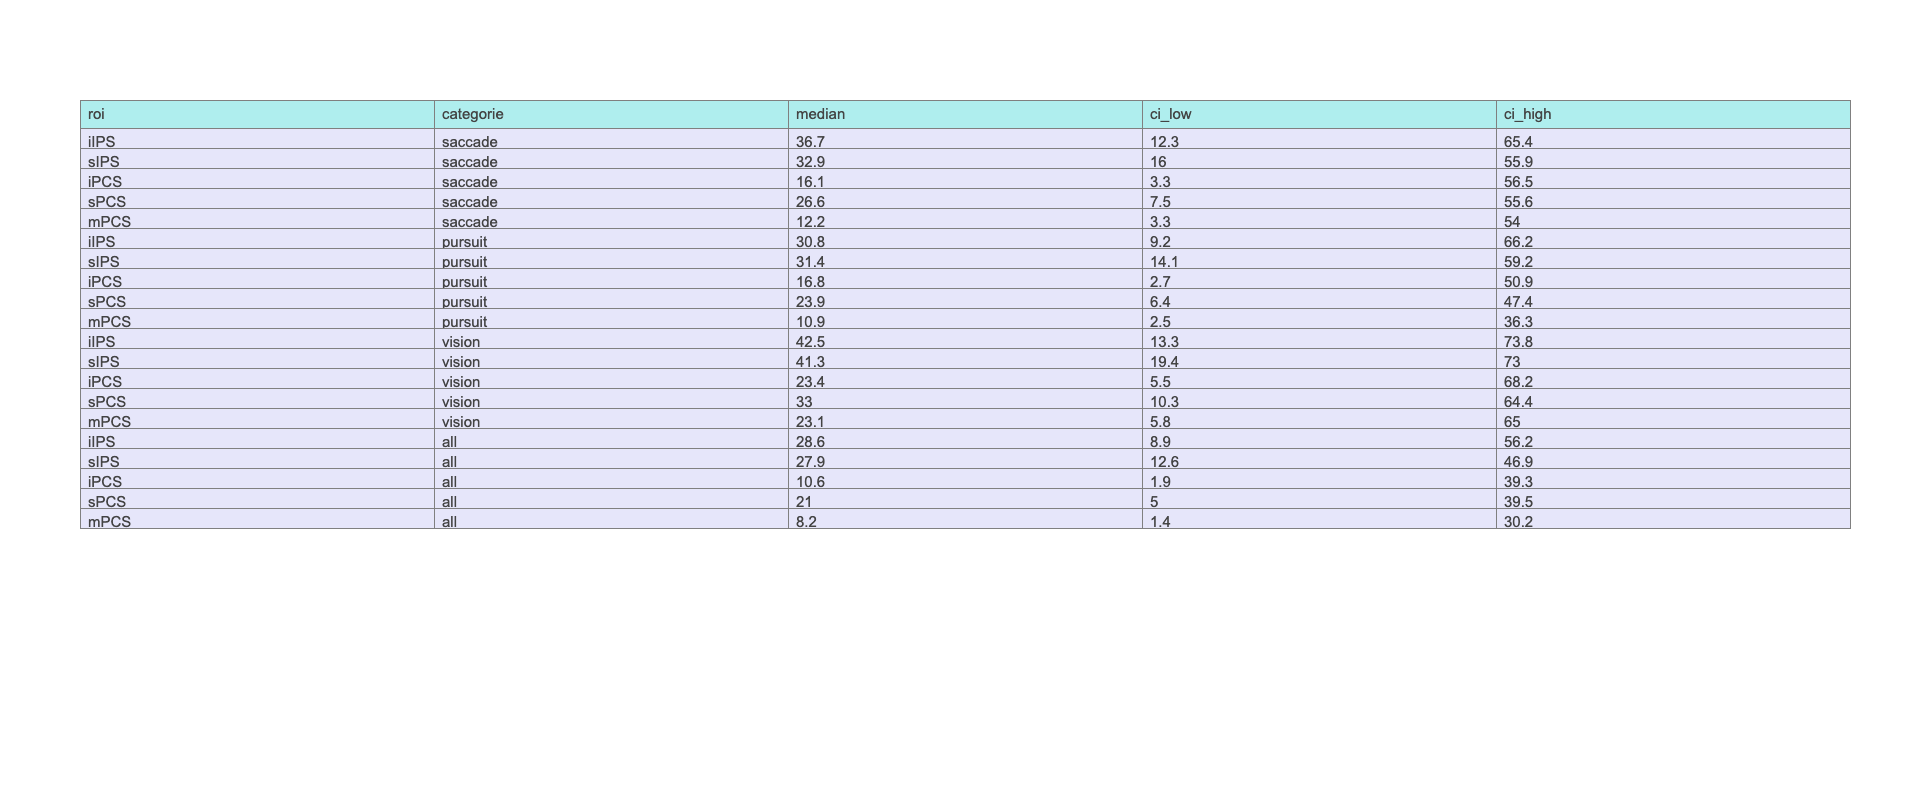

In [16]:
sub_rois =  ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

df_roi = df_active_vertex_roi.loc[df_active_vertex_roi['roi'].isin(sub_rois)]

fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(df_roi.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[df_roi[col].round(1) for col in df_roi.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=800, 
                  width=800)
# fig.write_image("/Users/uriel/Downloads/Surface_percentage_table.pdf".format(subject))
fig.show()

# Vertex bar plot MMP ROI

## Plot

In [7]:
# Specific settings
subject = 'group'
format_ = '170k'
suffix = 'Sac_Pur'
categories = ['saccade', 'pursuit', 'vision', 'all']
plot_groups = [['iIPS', 'sIPS', ''], ['iPCS', 'sPCS', 'mPCS']]

In [8]:
# Load DF 
tsv_dir = '{}/{}/derivatives/pp_data/{}/{}/intertask/tsv'.format(main_dir, project_dir, subject, format_)
active_vertex_roi_mmp_tsv_fn = '{}/{}_active_vertex_roi_mmp_{}.tsv'.format(tsv_dir, subject, suffix)

df_active_vertex_roi_mmp = pd.read_table(active_vertex_roi_mmp_tsv_fn)

In [9]:
categorie = 'all'
fig = active_vertex_roi_mmp_plot(df_active_vertex_roi_mmp=df_active_vertex_roi_mmp, fig_height=1080, fig_width=1080, roi_colors=roi_colors_dict, plot_groups=plot_groups, categorie=categorie)


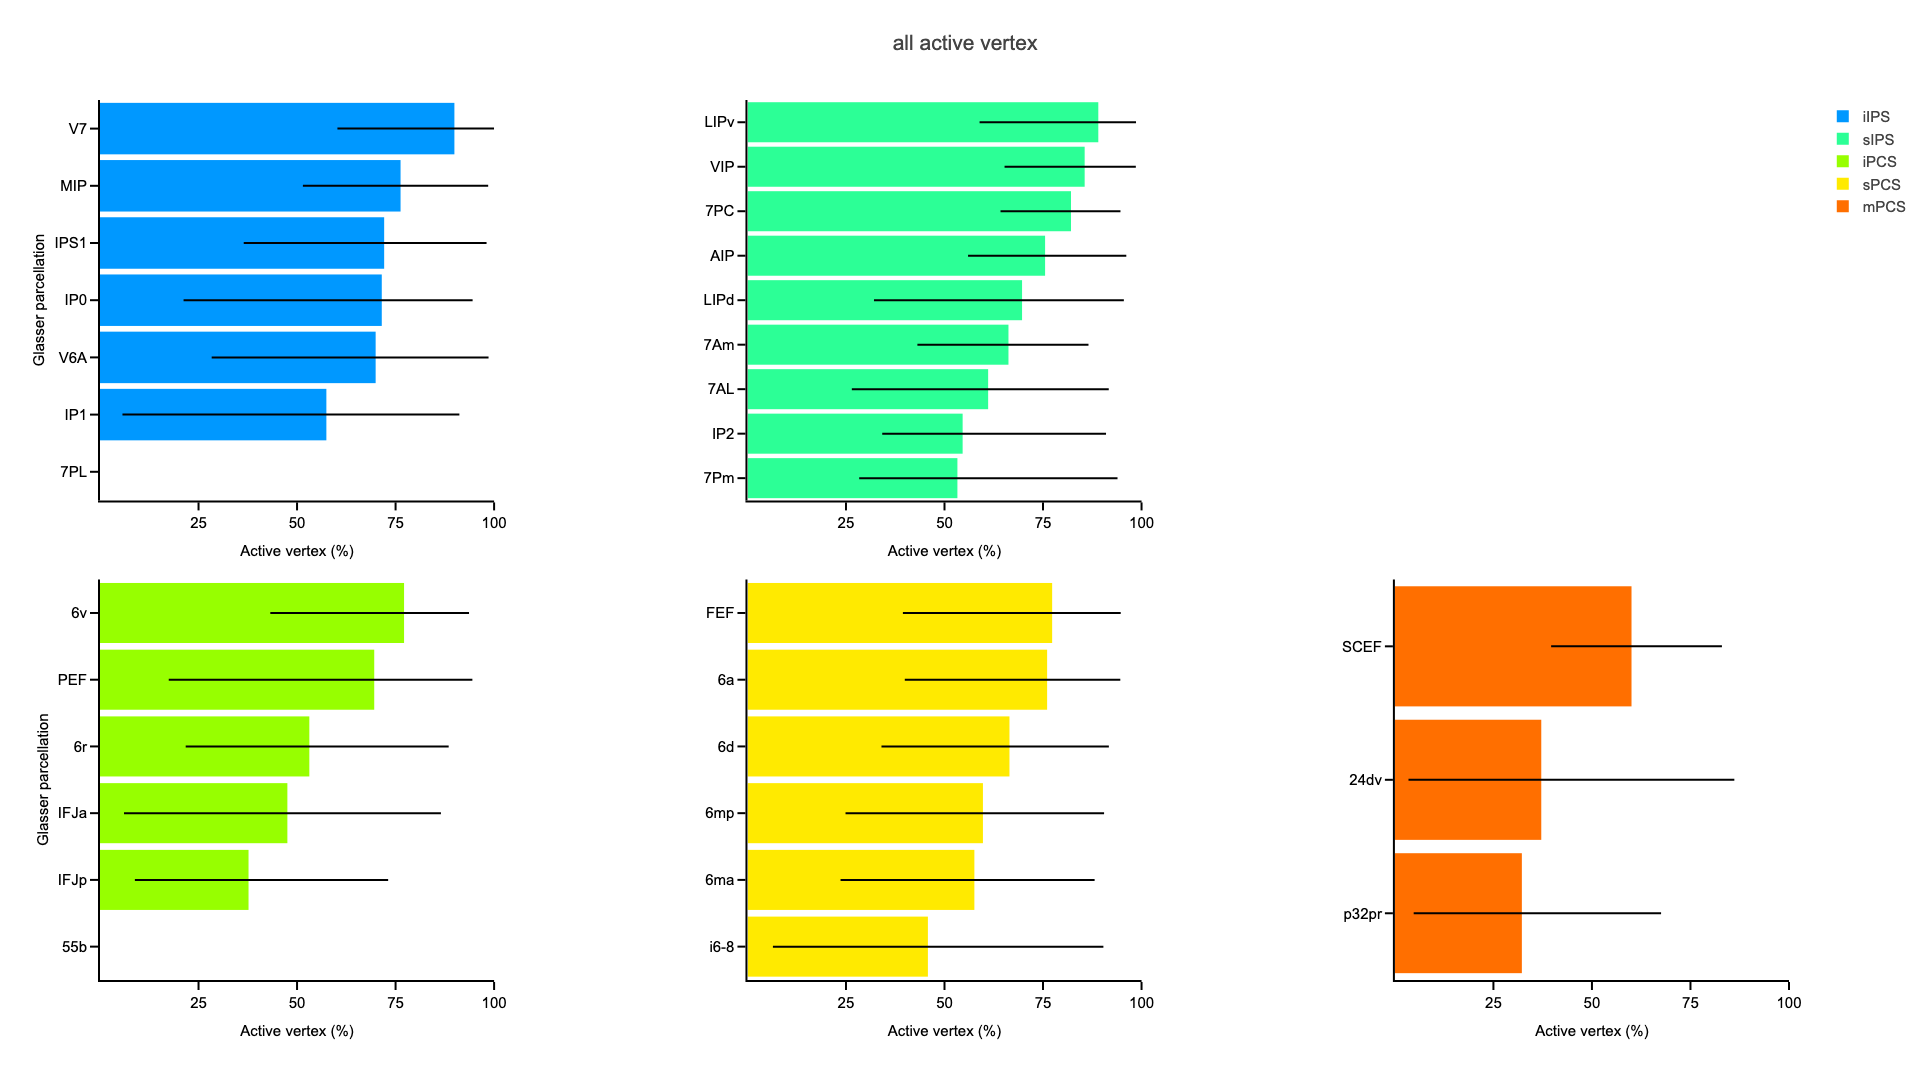

In [11]:
fig_dir = '/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/active_vertex/'
fig_fn = "{}/{}_active_vertex_{}_roi_mmp_{}.pdf".format(fig_dir, subject,categorie, suffix)
fig.write_image(fig_fn)
fig.show()

### Values

In [24]:
for group in plot_groups:
    for roi in group:
        subset = df_active_vertex_roi_mmp[
            (df_active_vertex_roi_mmp['roi'] == roi) & 
            (df_active_vertex_roi_mmp['categorie'] == 'all')
        ]
        min_value = subset['median'].min(skipna=True)
        max_value = subset['median'].max(skipna=True)
        min_roi = subset.loc[subset['median'] == min_value, 'roi_mmp'].iloc[0] if not subset[subset['median'] == min_value].empty else None
        max_roi = subset.loc[subset['median'] == max_value, 'roi_mmp'].iloc[0] if not subset[subset['median'] == max_value].empty else None

        print("for {:<10} value range is [{:.2f} ({}) - {:.2f} ({})]".format(roi, min_value, min_roi, max_value, max_roi))

for iIPS       value range is [0.00 (7PL) - 87.91 (V7)]
for sIPS       value range is [49.08 (IP2) - 88.02 (LIPv)]
for            value range is [nan (None) - nan (None)]
for iPCS       value range is [0.00 (55b) - 68.41 (6v)]
for sPCS       value range is [44.49 (i6-8) - 70.85 (FEF)]
for mPCS       value range is [23.13 (24dv) - 53.93 (SCEF)]


In [32]:
df_active_vertex_roi_mmp

roi roi_mmp categorie     median     ci_low    ci_high
0      V1      V1   saccade  86.675538  66.125209  96.619775
1      V2      V2   saccade  90.307573  65.340912  98.059583
2      V3      V3   saccade  86.612676  53.671859  97.313265
3      V3      V4   saccade  87.243208  59.885390  98.425845
4    V3AB     V3A   saccade  93.848348  71.108920  99.195576
..    ...     ...       ...        ...        ...        ...
207  sPCS     6mp       all  55.643163  21.628788  89.242799
208  sPCS     6ma       all  59.674797  24.445304  76.908086
209  mPCS    SCEF       all  55.899011  36.103201  78.790136
210  mPCS   p32pr       all  24.605294   5.095497  62.612851
211  mPCS    24dv       all  28.778195   1.927083  83.898066

[212 rows x 6 columns]

# Contralaterality plot

In [19]:
# Specific settings
subject = 'group'
format_ = '170k'
suffix = 'Sac_Pur'
rois = ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

In [12]:
# Load data
intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)
tsv_contralaterality_fn = "{}/{}_vision_and_pursuit_and_saccade_prf_contralaterality_{}.tsv".format(intertask_all_tsv_dir, subject, suffix)
df_contralaterality = pd.read_table(tsv_contralaterality_fn, sep="\t")

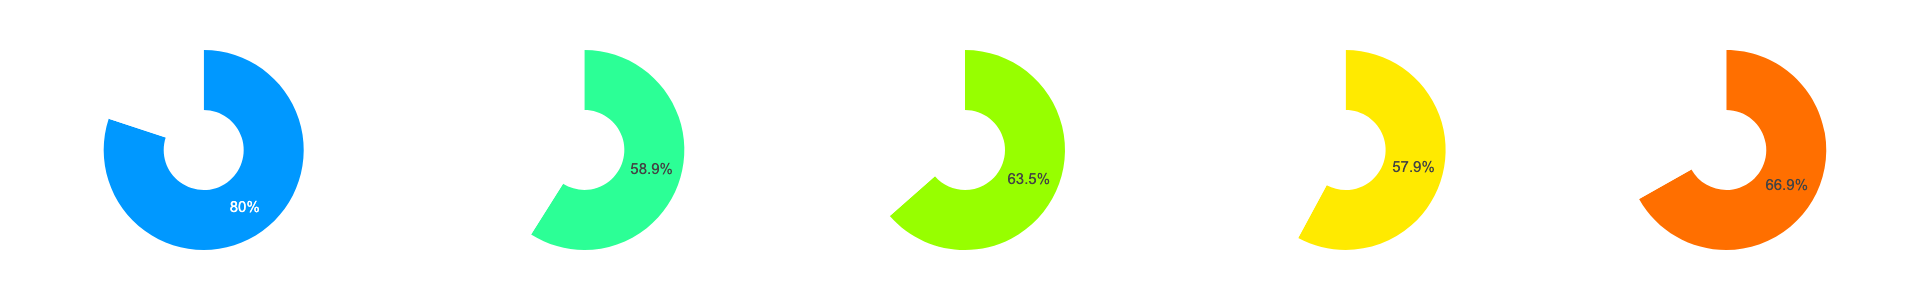

In [22]:
# Contralaterality plots
fig = prf_contralaterality_plot(df_contralaterality=df_contralaterality, 
                                fig_width=fig_width, fig_height=300, 
                                rois=rois, roi_colors=roi_colors_dict)



fig_dir = '/Users/uriel/Library/CloudStorage/Dropbox/retinomaps/figures/material/pRF_figures/'
fig_fn = "{}/{}_vision_and_pursuit_and_saccade_prf_contralaterality_{}.pdf".format(fig_dir, subject, suffix)

fig.write_image(fig_fn)
fig.show()


In [18]:
rois

['V1',
 'V2',
 'V3',
 'V3AB',
 'LO',
 'VO',
 'hMT+',
 'iIPS',
 'sIPS',
 'iPCS',
 'sPCS',
 'mPCS']